In [1]:
print("Hello")

Hello


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
def lin_interp(x, y, xq):
    """Simple linear interpolation y(xq) given tabulated (x,y)."""
    return np.interp(xq, x, y)

def nm_to_m(x_nm):
    return np.asarray(x_nm) * 1e-9

def um_to_m(x_um):
    return np.asarray(x_um) * 1e-6

# -----------------------------
# Photonics primitives (2x2)
# -----------------------------
def coupler_matrix(k=0.5):
    """
    Lossless symmetric directional coupler.
    k: power cross-coupling (0..1)
    """
    k = float(k)
    t = np.sqrt(1.0 - k)
    kap = np.sqrt(k)
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0, 0] = t
    matrix[0, 1] = 1j * kap
    matrix[1, 0] = 1j * kap
    matrix[1, 1] = t
    return matrix

def phase_matrix(phi):
    """Differential phase matrix."""
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0, 0] = np.exp(-1j * phi / 2.0)
    matrix[0, 1] = 0.0
    matrix[1, 0] = 0.0
    matrix[1, 1] = np.exp(+1j * phi / 2.0)
    return matrix

def delay_matrix(L_um, neff, wl_um, bias=0.0):
    """Delay matrix: P(phi) with phi = beta*L + bias."""
    phi = 2*np.pi*L_um*neff/wl_um + bias
    return phase_matrix(phi)

def leaf_matrix(lambda_um, neff_lambda, k_in, k_out, dL_um, phi_bias=0.0):
    """Single-stage MZI: C_out * P(phi) * C_in."""
    return (coupler_matrix(k_out) @ 
            delay_matrix(dL_um, neff_lambda, lambda_um, phi_bias) @ 
            coupler_matrix(k_in))

def root_matrix(lambda_um, neff_lambda, k1, k2, k3,
                dL0a_um, dL0b_um, phi0a_bias=0.0, phi0b_bias=0.0):
    """2-delay, 3-coupler root: C3 * P(phi_b) * C2 * P(phi_a) * C1."""
    return (coupler_matrix(k3) @ 
            delay_matrix(dL0b_um, neff_lambda, lambda_um, phi0b_bias) @
            coupler_matrix(k2) @
            delay_matrix(dL0a_um, neff_lambda, lambda_um, phi0a_bias) @
            coupler_matrix(k1))

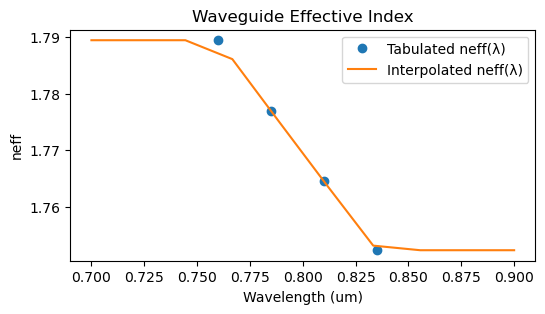


For wavelength 700.00 nm:
neff = 1.789460
Phase/um = 16.06 rad/um

For wavelength 722.22 nm:
neff = 1.789460
Phase/um = 15.57 rad/um

For wavelength 744.44 nm:
neff = 1.789460
Phase/um = 15.10 rad/um

For wavelength 766.67 nm:
neff = 1.786117
Phase/um = 14.64 rad/um

For wavelength 788.89 nm:
neff = 1.774987
Phase/um = 14.14 rad/um

For wavelength 811.11 nm:
neff = 1.763941
Phase/um = 13.66 rad/um

For wavelength 833.33 nm:
neff = 1.753109
Phase/um = 13.22 rad/um

For wavelength 855.56 nm:
neff = 1.752297
Phase/um = 12.87 rad/um

For wavelength 877.78 nm:
neff = 1.752297
Phase/um = 12.54 rad/um

For wavelength 900.00 nm:
neff = 1.752297
Phase/um = 12.23 rad/um


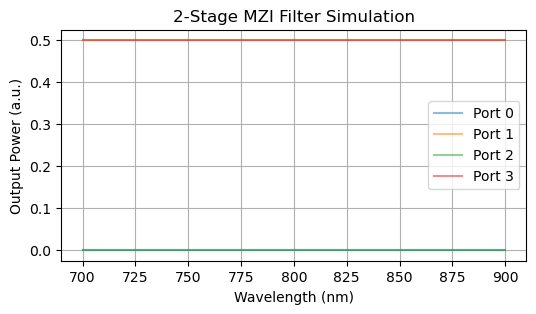

In [ ]:
# Simulate given
L1 = 6  # Root 1 um
L2 = 6  # Root 2 um
L3 = 3  # Leaf A um
L4 = 3  # leaf B um
k1 = 0.5  # Root coupler 1
k2 = 0.5  # Root coupler 2
k3 = 0.5  # Root coupler 3
k4 = 0.5  # Leaf coupler in
k5 = 0.5  # Leaf coupler out

# Simulation Range - All units um
wl_min = 700e-3
wl_max = 900e-3
num_points = 10

# Input injection
Ein = np.array([1.0, 0.0], dtype=complex)

# Fixed parameters - for interpolating neff(λ)
wg_neff = np.array([1.78946, 1.776922, 1.764483, 1.752297], dtype=float)  # TE
wg_lambda_um = np.array([0.760, 0.785, 0.810, 0.835], dtype=float)  # TE

# Prepare to simulate
# wavelength grid
wl_space_um = np.linspace(wl_min, wl_max, num_points)

# interpolate neff over grid
neff_interpd = np.interp(x = wl_space_um, xp = wg_lambda_um, fp = wg_neff)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(wg_lambda_um, wg_neff, 'o', label='Tabulated neff(λ)')
ax.plot(wl_space_um , neff_interpd, '-', label='Interpolated neff(λ)')
ax.set_title('Waveguide Effective Index')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('neff')
ax.legend()
plt.show()

# initialize output power
p0 = np.zeros_like(wl_space_um, dtype=float)
p1 = np.zeros_like(wl_space_um, dtype=float)
p2 = np.zeros_like(wl_space_um, dtype=float)
p3 = np.zeros_like(wl_space_um, dtype=float)

for i, wl in enumerate(wl_space_um):
    neff_wl = neff_interpd[i]
    print(f"\nFor wavelength {wl*1e3:.2f} nm:\nneff = {neff_wl:.6f}")
    print(f"Phase/um = {2*np.pi*neff_wl/wl:.2f} rad/um")
    # root
    root = root_matrix(wl, neff_wl, k1, k2, k3, um_to_m(L1), um_to_m(L2))
    Ebranch = root @ Ein
    E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
    # Upper is fed to leaf 1, lower to leaf 2

    # leaves
    leaf_a = leaf_matrix(wl, neff_wl, k4, k5, um_to_m(L3))
    leaf_b = leaf_matrix(wl, neff_wl, k4, k5, um_to_m(L4))

    Eout_leaf_1 = leaf_a @ np.array([E_to_leaf_1, 0.0], dtype=complex)
    Eout_leaf_2 = leaf_b @ np.array([E_to_leaf_2, 0.0], dtype=complex)
    p0[i] = np.abs(Eout_leaf_1[0])**2  # Port 0
    p1[i] = np.abs(Eout_leaf_1[1])**2  # Port 1
    p2[i] = np.abs(Eout_leaf_2[0])**2  # Port 2
    p3[i] = np.abs(Eout_leaf_2[1])**2  # Port 3



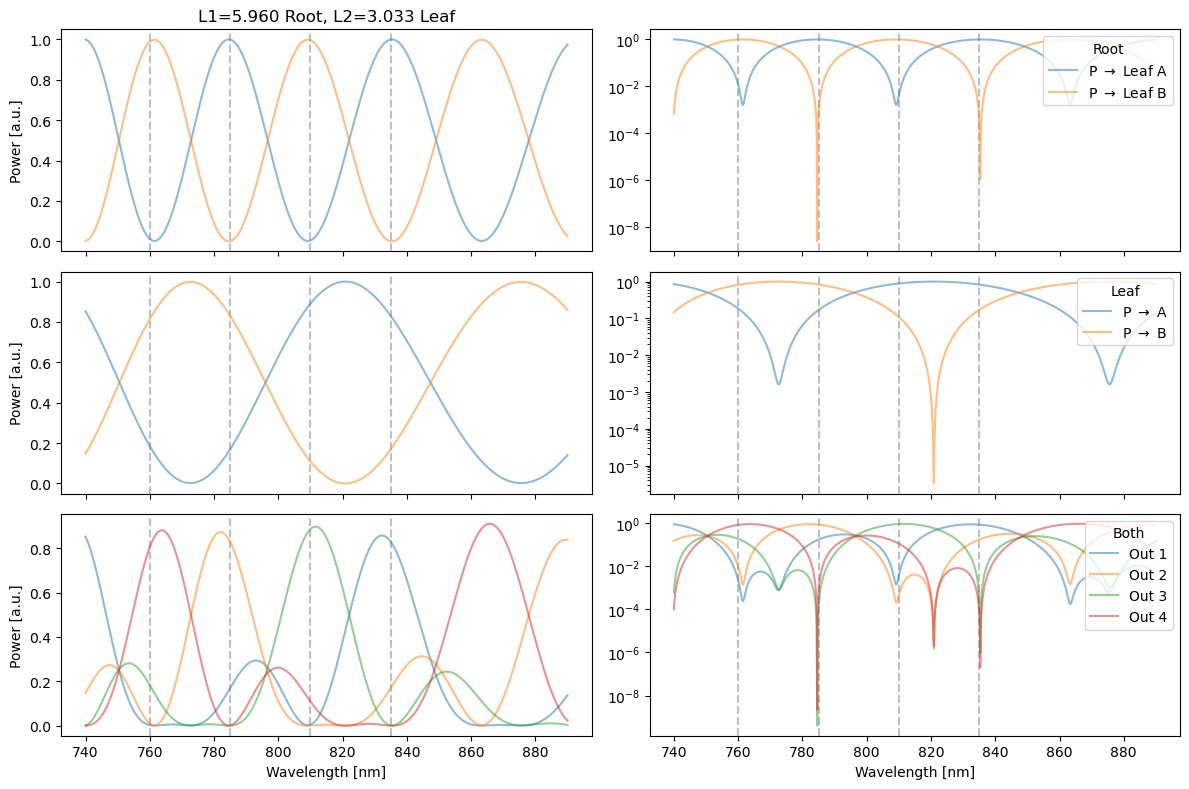

In [10]:


delay1 = 5.96
delay2 = 3.033

# delay1 = 6.033 - 0.075
# delay2 = 3.033 + 0.005

# delay1 = 5.7330
# delay2 = 3.1380
# Simulate given
L1 = delay1  # Root 1 um
L3 = delay2  # Leaf A um
L4 = delay2  # leaf B um

k = 0.52
k1 = k  # Root coupler 1
k2 = k  # Root coupler 2
k3 = k  # Root coupler 3
k4 = k  # Leaf coupler in
k5 = k  # Leaf coupler out

# Simulation Range - All units um
wl_min = 740e-3
wl_max = 890e-3
num_points = 1000
wl_space_um = np.linspace(wl_min, wl_max, num_points)

# Input injection
Ein = np.array([1.0, 0.0], dtype=complex)

# Fixed parameters - for interpolating neff(λ)
wg_neff = np.array([1.78946, 1.776922, 1.764483, 1.752297], dtype=float)  # TE
wl_um = np.array([0.760, 0.785, 0.810, 0.835], dtype=float)  # TE
# Interpolate neff with a linear fit
def linfit(x, m, b=0):
    return m*x + b
pOpt, pCov = curve_fit(linfit, wl_um, wg_neff)
def neff_fit_func(wl_um):
    return linfit(wl_um, *pOpt)

p_a = []
p_b = []
p_l1 = []
p_l2 = []
p_l3 = []
p_l4 = []
p_leaf_test1 = []
p_leaf_test2 = []
for i, wl in enumerate(wl_space_um):
    n_eff_wl = neff_fit_func(wl)
    phi_per_um = 2*np.pi*n_eff_wl/wl

    # Root
    DC1 = coupler_matrix(k1)
    DC2 = coupler_matrix(k2)
    P1 = delay_matrix(L1, n_eff_wl, wl)
    root = DC2 @ P1 @ DC1
    
    Ebranch = root @ Ein
    E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
    p_a.append(np.abs(E_to_leaf_1)**2)
    p_b.append(np.abs(E_to_leaf_2)**2)

    E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
    E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)
    # Leaf A
    DC4 = coupler_matrix(k4)  # Leaf A
    DC5 = coupler_matrix(k5)  # Leaf A
    P3 = delay_matrix(L3, n_eff_wl, wl)  # Leaf A
    leaf_a = DC5 @ P3 @ DC4
    
    EleafA = leaf_a @ Ein
    EA_1, EA_2 = EleafA[0], EleafA[1]
    p_leaf_test1.append(np.abs(EA_1)**2)
    p_leaf_test2.append(np.abs(EA_2)**2)
    EleafA = leaf_a @ E_input_to_leaf_1
    EA_1, EA_2 = EleafA[0], EleafA[1]

    # Leaf B
    DC6 = coupler_matrix(k4)  # Leaf B
    DC7 = coupler_matrix(k5)  # Leaf B
    P4 = delay_matrix(L4, n_eff_wl, wl)  # Leaf
    leaf_b = DC7 @ P4 @ DC6

    EleafB = leaf_b @ E_input_to_leaf_2
    EB_1, EB_2 = EleafB[0], EleafB[1]

    p_l1.append(np.abs(EA_1)**2)
    p_l2.append(np.abs(EA_2)**2)
    p_l3.append(np.abs(EB_1)**2)
    p_l4.append(np.abs(EB_2)**2)
    # break

fig, axs = plt.subplots(3, 2, figsize=(12,8), sharex=True)
ax_root_lin, ax_root_log = axs[0]
ax_leaf1_lin, ax_leaf1_log = axs[1]
ax_leaf2_lin, ax_leaf2_log = axs[2]

# Linear scale plots (left column)
for wl_target in wl_um:
    ax_root_lin.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf1_lin.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf2_lin.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)

ax_root_lin.plot(wl_space_um * 1e3, p_a, label='Power to Leaf A', alpha=0.5)
ax_root_lin.plot(wl_space_um * 1e3, p_b, label='Power to Leaf B', alpha=0.5)
ax_root_lin.set_title(f'L1={L1:.3f} Root, L2={L3} Leaf')
ax_root_lin.set_ylabel('Power [a.u.]')
# ax_root_lin.legend(loc='upper right')

ax_leaf1_lin.plot(wl_space_um * 1e3, p_leaf_test1, label='Out1', alpha=0.5)
ax_leaf1_lin.plot(wl_space_um * 1e3, p_leaf_test2, label='Out2', alpha=0.5)
ax_leaf1_lin.set_ylabel('Power [a.u.]')
# ax_leaf1_lin.legend(loc='upper right')

ax_leaf2_lin.plot(wl_space_um * 1e3, p_l1, label='Out1', alpha=0.5)
ax_leaf2_lin.plot(wl_space_um * 1e3, p_l2, label='Out2', alpha=0.5)
ax_leaf2_lin.plot(wl_space_um * 1e3, p_l3, label='Out3', alpha=0.5)
ax_leaf2_lin.plot(wl_space_um * 1e3, p_l4, label='Out4', alpha=0.5)
ax_leaf2_lin.set_xlabel('Wavelength [nm]')
ax_leaf2_lin.set_ylabel('Power [a.u.]')
# ax_leaf2_lin.legend(loc='upper right')

# Log scale plots (right column)
for wl_target in wl_um:
    ax_root_log.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf1_log.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)
    ax_leaf2_log.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)

ax_root_log.plot(wl_space_um * 1e3, p_a, label=r'P $\rightarrow$ Leaf A', alpha=0.5)
ax_root_log.plot(wl_space_um * 1e3, p_b, label=r'P $\rightarrow$ Leaf B', alpha=0.5)
ax_root_log.set_yscale('log')
ax_root_log.legend(loc='upper right', title="Root")

ax_leaf1_log.plot(wl_space_um * 1e3, p_leaf_test1, label=r'P $\rightarrow$ A', alpha=0.5)
ax_leaf1_log.plot(wl_space_um * 1e3, p_leaf_test2, label=r'P $\rightarrow$ B', alpha=0.5)
ax_leaf1_log.set_yscale('log')
ax_leaf1_log.legend(loc='upper right', title='Leaf')

ax_leaf2_log.plot(wl_space_um * 1e3, p_l1, label='Out 1', alpha=0.5)
ax_leaf2_log.plot(wl_space_um * 1e3, p_l2, label='Out 2', alpha=0.5)
ax_leaf2_log.plot(wl_space_um * 1e3, p_l3, label='Out 3', alpha=0.5)
ax_leaf2_log.plot(wl_space_um * 1e3, p_l4, label='Out 4', alpha=0.5)
ax_leaf2_log.set_xlabel('Wavelength [nm]')
ax_leaf2_log.set_yscale('log')
ax_leaf2_log.legend(loc='upper right', title='Both')

plt.tight_layout()
plt.show()

/tmp/ipykernel_592317/43623501.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


Channel Powers:
  Output 1: 0.0597 (5.97%)
  Output 2: 0.0083 (0.83%)
  Output 3: 0.8168 (81.68%)
  Output 4: 0.1152 (11.52%)
Running: L1=5.9600 µm, L3=L4=3.0330 µm
  → Demux Efficiency: 0.821 (82.1%)



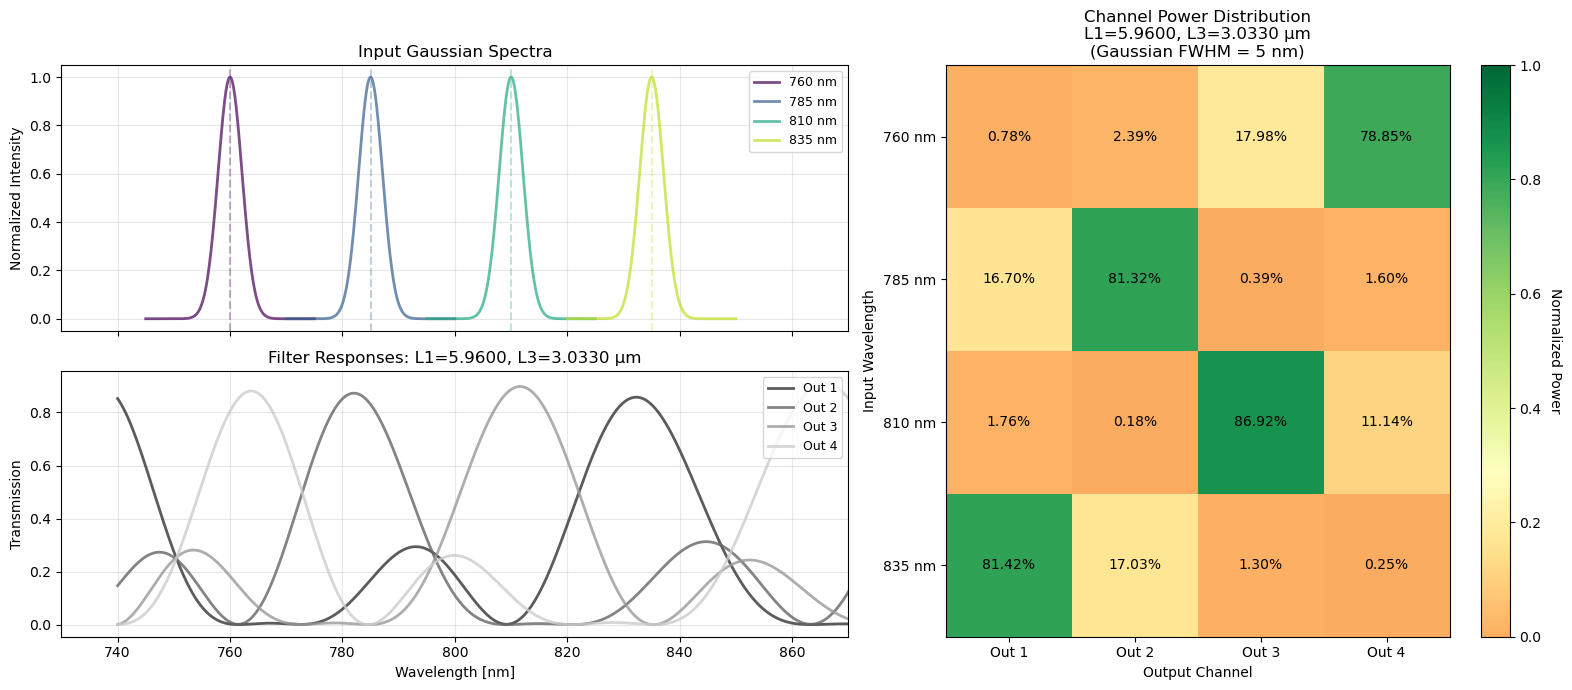

Running: L1=5.7330 µm, L3=L4=3.1380 µm
  → Demux Efficiency: 0.846 (84.6%)



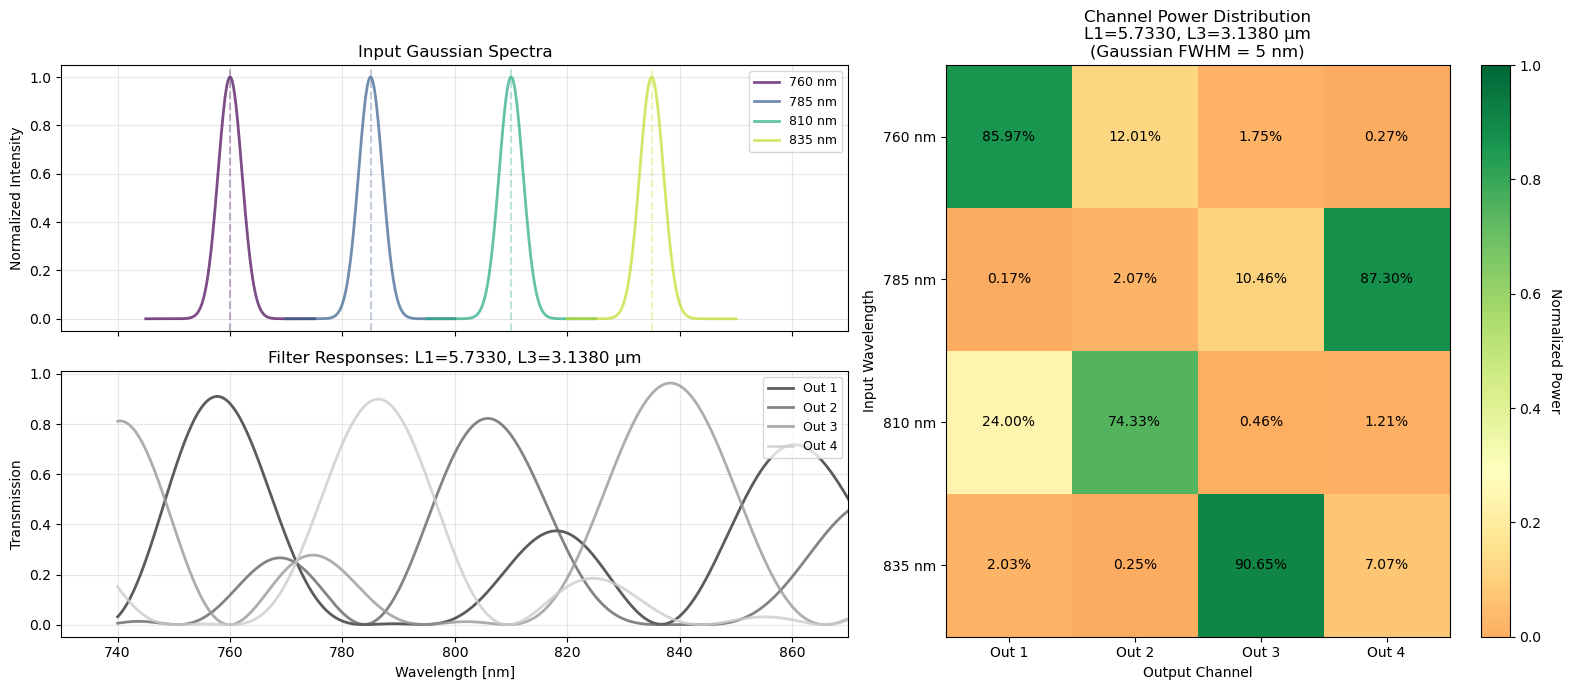

Running: L1=5.7310 µm, L3=L4=3.1475 µm
  → Demux Efficiency: 0.849 (84.9%)



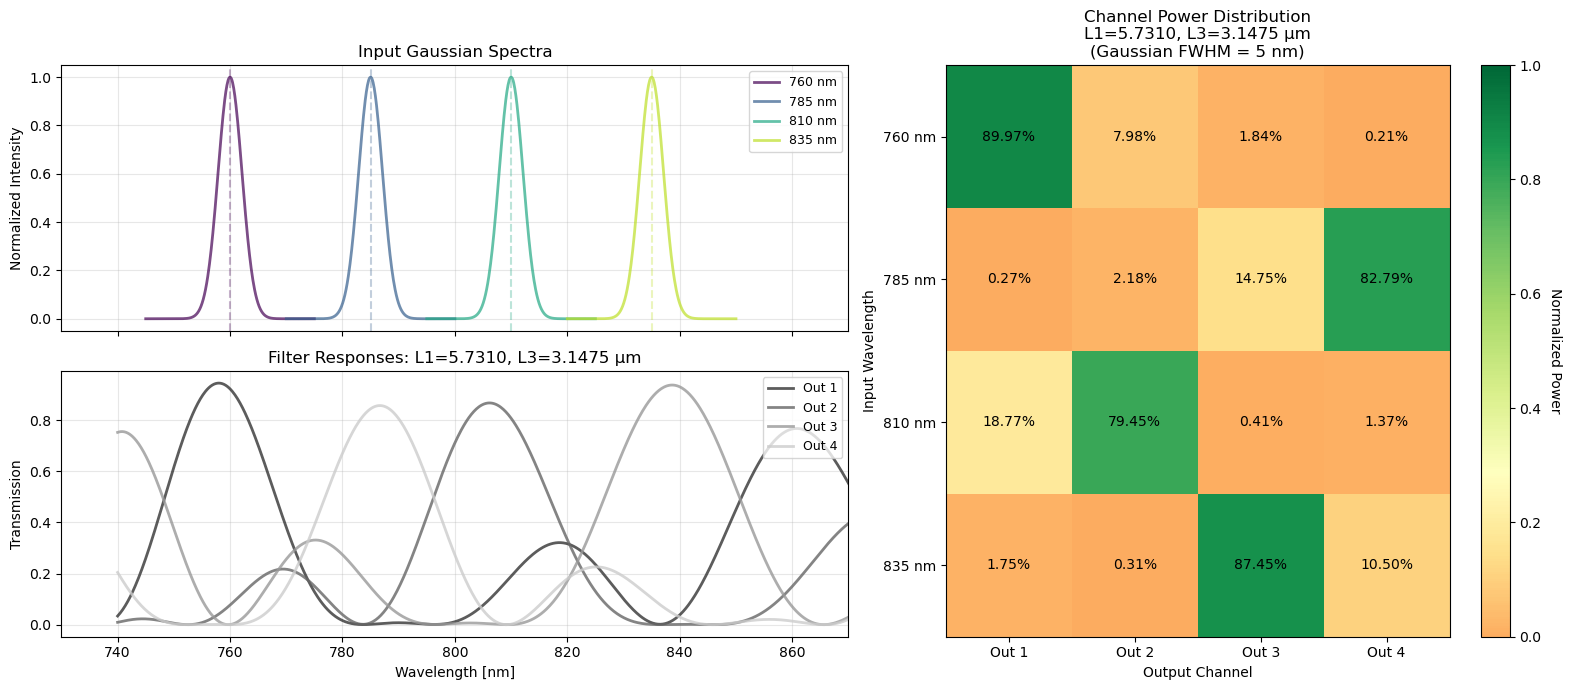

Running: L1=5.7310 µm, L3=L4=3.1718 µm
  → Demux Efficiency: 0.830 (83.0%)



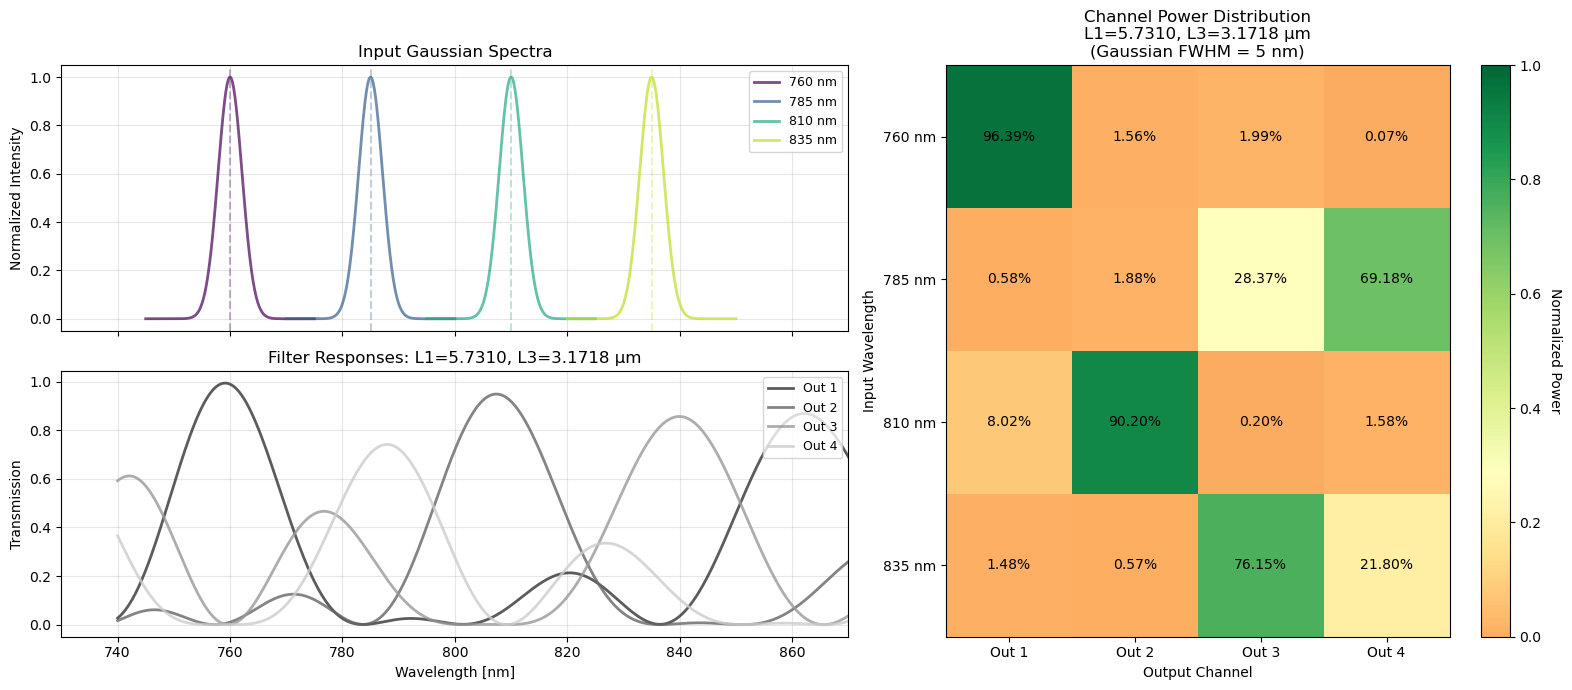

In [ ]:
from matplotlib import cm, colors

def trim_colormap(cmap_name, vmin=0.0, vmax=1.0, n=256):
    """
    Return a new colormap that is a trimmed version of an existing one.

    Parameters
    ----------
    cmap_name : str or Colormap
        Name of a matplotlib colormap (e.g. 'viridis', 'YlGnBu')
    vmin, vmax : float
        Fractional range [0,1] to keep from the original colormap
    n : int
        Number of color samples
    """
    cmap = cm.get_cmap(cmap_name)
    new_colors = cmap(np.linspace(vmin, vmax, n))
    return colors.LinearSegmentedColormap.from_list(
        f"{cmap.name}_trim_{vmin}_{vmax}", new_colors
    )
custom_cmap = trim_colormap("RdYlGn", vmin=0.3, vmax=1.0)

def calculate_channel_powers(lambda_center_nm, fwhm_nm, 
                            L1=5.958, L3=3.033, L4=3.033, 
                            k1=0.5, k2=0.5, k4=0.5, k5=0.5):
    """
    Calculate the power output at each channel for the MZI filter given an input 
    with a Gaussian spectrum centered at lambda_center_nm with FWHM of fwhm_nm.
    
    Parameters:
    -----------
    lambda_center_nm : float
        Center wavelength of input signal in nm
    fwhm_nm : float
        Full-width at half-maximum of input Gaussian spectrum in nm
    L1 : float
        Root delay length in um (default: 5.958)
    L3 : float
        Leaf A delay length in um (default: 3.038)
    L4 : float
        Leaf B delay length in um (default: 3.038)
    k1, k2 : float
        Root coupler coefficients (default: 0.5)
    k4, k5 : float
        Leaf coupler coefficients (default: 0.5)
        
    Returns:
    --------
    dict : Dictionary containing:
        - 'channel_powers': array of integrated powers [P1, P2, P3, P4]
        - 'wavelengths_nm': wavelength grid used
        - 'input_spectrum': input Gaussian spectrum
        - 'output_spectra': dict with keys 'out1', 'out2', 'out3', 'out4'
    """
    # Convert to um
    lambda_center_um = lambda_center_nm * 1e-3
    fwhm_um = fwhm_nm * 1e-3
    
    # Create wavelength grid around the center wavelength
    wl_range_um = 3 * fwhm_um  # Cover ±3 FWHM
    num_pts = 500
    wl_grid_um = np.linspace(lambda_center_um - wl_range_um, 
                             lambda_center_um + wl_range_um, 
                             num_pts)
    
    # Create Gaussian input spectrum
    sigma = fwhm_um / (2 * np.sqrt(2 * np.log(2)))
    input_spectrum = np.exp(-0.5 * ((wl_grid_um - lambda_center_um) / sigma)**2)
    
    # Initialize output powers
    p_out1 = np.zeros(num_pts)
    p_out2 = np.zeros(num_pts)
    p_out3 = np.zeros(num_pts)
    p_out4 = np.zeros(num_pts)
    
    # Simulate for each wavelength
    for i, wl in enumerate(wl_grid_um):
        n_eff_wl = neff_fit_func(wl)
        
        # Root stage
        DC1 = coupler_matrix(k1)
        DC2 = coupler_matrix(k2)
        P1 = delay_matrix(L1, n_eff_wl, wl)
        root = DC2 @ P1 @ DC1
        
        Ebranch = root @ Ein
        E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
        
        # Leaf A
        DC4 = coupler_matrix(k4)
        DC5 = coupler_matrix(k5)
        P3 = delay_matrix(L3, n_eff_wl, wl)
        leaf_a = DC5 @ P3 @ DC4
        
        E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
        EleafA = leaf_a @ E_input_to_leaf_1
        
        # Leaf B
        DC6 = coupler_matrix(k4)
        DC7 = coupler_matrix(k5)
        P4 = delay_matrix(L4, n_eff_wl, wl)
        leaf_b = DC7 @ P4 @ DC6
        
        E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)
        EleafB = leaf_b @ E_input_to_leaf_2
        
        # Calculate powers weighted by input spectrum
        p_out1[i] = np.abs(EleafA[0])**2 * input_spectrum[i]
        p_out2[i] = np.abs(EleafA[1])**2 * input_spectrum[i]
        p_out3[i] = np.abs(EleafB[0])**2 * input_spectrum[i]
        p_out4[i] = np.abs(EleafB[1])**2 * input_spectrum[i]
    
    # Integrate to get total power in each channel
    channel_powers = np.array([
        np.trapz(p_out1, wl_grid_um),
        np.trapz(p_out2, wl_grid_um),
        np.trapz(p_out3, wl_grid_um),
        np.trapz(p_out4, wl_grid_um)
    ])
    
    # Normalize
    total_power = np.sum(channel_powers)
    if total_power > 0:
        channel_powers /= total_power
    
    return {
        'channel_powers': channel_powers,
        'wavelengths_nm': wl_grid_um * 1e3,
        'input_spectrum': input_spectrum,
        'output_spectra': {
            'out1': p_out1,
            'out2': p_out2,
            'out3': p_out3,
            'out4': p_out4
        }
    }

k = 0.52
# Example usage
result = calculate_channel_powers(
    lambda_center_nm=810,
    fwhm_nm=10,
    L1=L1,
    L3=L3,
    L4=L4,
    k1=k,
    k2=k,
    k4=k,
    k5=k
)

print("Channel Powers:")
for i, p in enumerate(result['channel_powers'], 1):
    print(f"  Output {i}: {p:.4f} ({p*100:.2f}%)")


test_lasers = [(760, 5), 
               (785, 5), 
               (810, 5), 
               (835, 5)]

# Collect results for all test lasers

delays_to_vis = [(5.96, 3.033),
                 (5.7330, 3.1380),
                 (5.7310, 3.1475),
                 (5.7310, 3.1718)
                 ]

for delay1, delay2 in delays_to_vis:
    print(f"Running: L1={delay1:.4f} µm, L3=L4={delay2:.4f} µm")

    # Recalculate filter bands for this configuration
    p_l1_temp = []
    p_l2_temp = []
    p_l3_temp = []
    p_l4_temp = []
    
    for wl in wl_space_um:
        n_eff_wl = neff_fit_func(wl)
        
        # Root stage with current delay1
        DC1 = coupler_matrix(k1)
        DC2 = coupler_matrix(k2)
        P1 = delay_matrix(delay1, n_eff_wl, wl)
        root = DC2 @ P1 @ DC1
        
        Ebranch = root @ Ein
        E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
        
        E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
        E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)
        
        # Leaf A with current delay2
        DC4 = coupler_matrix(k4)
        DC5 = coupler_matrix(k5)
        P3 = delay_matrix(delay2, n_eff_wl, wl)
        leaf_a = DC5 @ P3 @ DC4
        EleafA = leaf_a @ E_input_to_leaf_1
        EA_1, EA_2 = EleafA[0], EleafA[1]
        
        # Leaf B with current delay2
        DC6 = coupler_matrix(k4)
        DC7 = coupler_matrix(k5)
        P4 = delay_matrix(delay2, n_eff_wl, wl)
        leaf_b = DC7 @ P4 @ DC6
        EleafB = leaf_b @ E_input_to_leaf_2
        EB_1, EB_2 = EleafB[0], EleafB[1]
        
        p_l1_temp.append(np.abs(EA_1)**2)
        p_l2_temp.append(np.abs(EA_2)**2)
        p_l3_temp.append(np.abs(EB_1)**2)
        p_l4_temp.append(np.abs(EB_2)**2)
    
    # Calculate channel powers for heatmap
    results_matrix = np.zeros((len(test_lasers), 4))
    for i, (wl, fwhm) in enumerate(test_lasers):
        result = calculate_channel_powers(
            lambda_center_nm=wl,
            fwhm_nm=fwhm,
            L1=delay1,
            L3=delay2,
            L4=delay2,
        )
        results_matrix[i, :] = result['channel_powers']

    # Create figure with 3 subplots (2 on left, 1 on right)
    fig = plt.figure(figsize=(16, 7))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.8], height_ratios=[1, 1])
    ax_gauss = fig.add_subplot(gs[0, 0])
    ax_filter = fig.add_subplot(gs[1, 0], sharex=ax_gauss)
    ax_heat = fig.add_subplot(gs[:, 1])

    # Top left plot: Gaussian input distributions
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(test_lasers)))
    for i, (wl_center, fwhm) in enumerate(test_lasers):
        # Create Gaussian
        wl_center_um = wl_center * 1e-3
        fwhm_um = fwhm * 1e-3
        sigma = fwhm_um / (2 * np.sqrt(2 * np.log(2)))
        wl_range = 3 * fwhm_um
        wl_grid = np.linspace(wl_center_um - wl_range, wl_center_um + wl_range, 300)
        gaussian = np.exp(-0.5 * ((wl_grid - wl_center_um) / sigma)**2)
        
        ax_gauss.plot(wl_grid * 1e3, gaussian, label=f'{wl_center} nm', 
                    linewidth=2, color=colors[i], alpha=0.7)
        ax_gauss.axvline(wl_center, color=colors[i], linestyle='--', alpha=0.3)

    ax_gauss.set_ylabel('Normalized Intensity')
    ax_gauss.set_title('Input Gaussian Spectra')
    ax_gauss.legend(loc='upper right', fontsize=9)
    ax_gauss.grid(True, alpha=0.3)
    ax_gauss.set_xlim(730, 870)
    ax_gauss.tick_params(labelbottom=False)

    # Bottom left plot: Filter band responses (from previous cell)
    greys = [f'{g}' for g in [0.2, 0.4, 0.6, 0.8]]
    ax_filter.plot(wl_space_um * 1e3, p_l1_temp, label='Out 1', linewidth=2, color=greys[0], alpha=0.8)
    ax_filter.plot(wl_space_um * 1e3, p_l2_temp, label='Out 2', linewidth=2, color=greys[1], alpha=0.8)
    ax_filter.plot(wl_space_um * 1e3, p_l3_temp, label='Out 3', linewidth=2, color=greys[2], alpha=0.8)
    ax_filter.plot(wl_space_um * 1e3, p_l4_temp, label='Out 4', linewidth=2, color=greys[3], alpha=0.8)

    ax_filter.set_xlabel('Wavelength [nm]')
    ax_filter.set_ylabel('Transmission')
    ax_filter.set_title(f'Filter Responses: L1={delay1:.4f}, L3={delay2:.4f} µm')
    ax_filter.legend(loc='upper right', fontsize=9)
    ax_filter.grid(True, alpha=0.3)

    # Right plot: Heatmap
    im = ax_heat.imshow(results_matrix, cmap=custom_cmap, aspect='auto', vmin=0, vmax=1)

    # Set ticks and labels
    ax_heat.set_xticks(np.arange(4))
    ax_heat.set_yticks(np.arange(len(test_lasers)))
    ax_heat.set_xticklabels([f'Out {i+1}' for i in range(4)])
    ax_heat.set_yticklabels([f'{wl} nm' for wl, _ in test_lasers])

    # Add text annotations
    for i in range(len(test_lasers)):
        for j in range(4):
            text = ax_heat.text(j, i, f'{results_matrix[i, j]:.2%}',
                        ha="center", va="center", color="black", fontsize=10)

    ax_heat.set_xlabel('Output Channel')
    ax_heat.set_ylabel('Input Wavelength')
    ax_heat.set_title(f'Channel Power Distribution\nL1={delay1:.4f}, L3={delay2:.4f} µm\n(Gaussian FWHM = 5 nm)')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax_heat)
    cbar.set_label('Normalized Power', rotation=270, labelpad=15)
    
    # Calculate and display metrics for this configuration
    channel_purity_temp = np.max(results_matrix, axis=1)
    demux_efficiency_temp = np.mean(channel_purity_temp)
    print(f"  → Demux Efficiency: {demux_efficiency_temp:.3f} ({demux_efficiency_temp*100:.1f}%)")
    print()

    plt.tight_layout()
    plt.show()


## Filter Performance Metrics

Several figures of merit can evaluate how well the filter separates wavelength channels:

1. **Channel Purity**: Fraction of power going to the dominant output (higher is better)
2. **Extinction Ratio**: Ratio between dominant and second-strongest channel in dB (higher is better)
3. **Crosstalk**: Power leaking to unintended channels in dB (more negative is better)
4. **Demux Efficiency**: Average maximum power across all inputs (higher is better)

In [ ]:
# Calculate filter performance metrics
print("="*60)
print("FILTER PERFORMANCE METRICS")
print("="*60)

# 1. Channel Purity (max power in each row)
channel_purity = np.max(results_matrix, axis=1)
avg_purity = np.mean(channel_purity)
print(f"\n1. Channel Purity (fraction to dominant channel):")
for i, (wl, _) in enumerate(test_lasers):
    print(f"   {wl} nm: {channel_purity[i]:.3f} ({channel_purity[i]*100:.1f}%)")
print(f"   Average: {avg_purity:.3f} ({avg_purity*100:.1f}%)")

# 2. Extinction Ratio (dominant vs second strongest)
print(f"\n2. Extinction Ratio (dominant / 2nd strongest):")
extinction_ratios_db = []
for i, (wl, _) in enumerate(test_lasers):
    sorted_powers = np.sort(results_matrix[i, :])[::-1]
    if sorted_powers[1] > 0:
        er_db = 10 * np.log10(sorted_powers[0] / sorted_powers[1])
        extinction_ratios_db.append(er_db)
        print(f"   {wl} nm: {er_db:.1f} dB")
    else:
        print(f"   {wl} nm: ∞ dB (perfect)")
        extinction_ratios_db.append(np.inf)

if np.all(np.isfinite(extinction_ratios_db)):
    print(f"   Average: {np.mean(extinction_ratios_db):.1f} dB")

# 3. Crosstalk (power to non-dominant channels)
print(f"\n3. Crosstalk (power to unintended channels):")
for i, (wl, _) in enumerate(test_lasers):
    max_power = np.max(results_matrix[i, :])
    crosstalk = 1 - max_power
    if max_power > 0 and crosstalk > 0:
        crosstalk_db = 10 * np.log10(crosstalk / max_power)
        print(f"   {wl} nm: {crosstalk_db:.1f} dB ({crosstalk*100:.1f}%)")
    else:
        print(f"   {wl} nm: -∞ dB (perfect)")

# 4. Overall Demux Efficiency
demux_efficiency = np.mean(channel_purity)
print(f"\n4. Overall Demux Efficiency: {demux_efficiency:.3f} ({demux_efficiency*100:.1f}%)")

# 5. Which output channel is dominant for each input?
print(f"\n5. Wavelength → Output Channel Mapping:")
for i, (wl, _) in enumerate(test_lasers):
    dominant_channel = np.argmax(results_matrix[i, :]) + 1
    print(f"   {wl} nm → Output {dominant_channel} ({channel_purity[i]*100:.1f}% of power)")

print("="*60)

FILTER PERFORMANCE METRICS

1. Channel Purity (fraction to dominant channel):
   760 nm: 0.790 (79.0%)
   785 nm: 0.813 (81.3%)
   810 nm: 0.868 (86.8%)
   835 nm: 0.815 (81.5%)
   Average: 0.821 (82.1%)

2. Extinction Ratio (dominant / 2nd strongest):
   760 nm: 6.4 dB
   785 nm: 6.9 dB
   810 nm: 8.9 dB
   835 nm: 6.8 dB
   Average: 7.3 dB

3. Crosstalk (power to unintended channels):
   760 nm: -5.8 dB (21.0%)
   785 nm: -6.4 dB (18.7%)
   810 nm: -8.2 dB (13.2%)
   835 nm: -6.4 dB (18.5%)

4. Overall Demux Efficiency: 0.821 (82.1%)

5. Wavelength → Output Channel Mapping:
   760 nm → Output 4 (79.0% of power)
   785 nm → Output 2 (81.3% of power)
   810 nm → Output 3 (86.8% of power)
   835 nm → Output 1 (81.5% of power)


## Parameter Sweep for Tapeout Optimization

Quick optimization to find the best delay lengths by sweeping small variations around the nominal values.

**Figure of Merit:** Weighted Demux Efficiency prioritizing 810 nm (3× weight) for clean filtering.

Figure of Merit: Weighted Demux Efficiency
Wavelength weights:
  760 nm: 1.0× → 0.167 normalized
  785 nm: 1.0× → 0.167 normalized
  810 nm: 3.0× → 0.500 normalized
  835 nm: 1.0× → 0.167 normalized

Running 75 × 75 = 5625 simulations...
L1 range: 5.6580 to 6.2580 µm (step: 0.00811 µm)
L3 range: 2.8880 to 3.1880 µm (step: 0.00405 µm)
Starting sweep...

  Progress: 9% complete (48.6s elapsed)
  Progress: 19% complete (94.1s elapsed)
  Progress: 28% complete (141.1s elapsed)
  Progress: 37% complete (187.0s elapsed)
  Progress: 47% complete (233.3s elapsed)
  Progress: 56% complete (280.4s elapsed)
  Progress: 65% complete (326.0s elapsed)
  Progress: 75% complete (374.3s elapsed)
  Progress: 84% complete (421.7s elapsed)
  Progress: 93% complete (466.9s elapsed)

✓ Sweep complete!
  Total time: 499.07 seconds (8.32 minutes)
  Time per simulation: 88.72 ms

OPTIMAL PARAMETERS (weighted for 810 nm):
  L1 = 5.7310 µm (Δ = -0.2270 µm)
  L3 = L4 = 3.1718 µm (Δ = +0.1338 µm)
  Weighted Effici

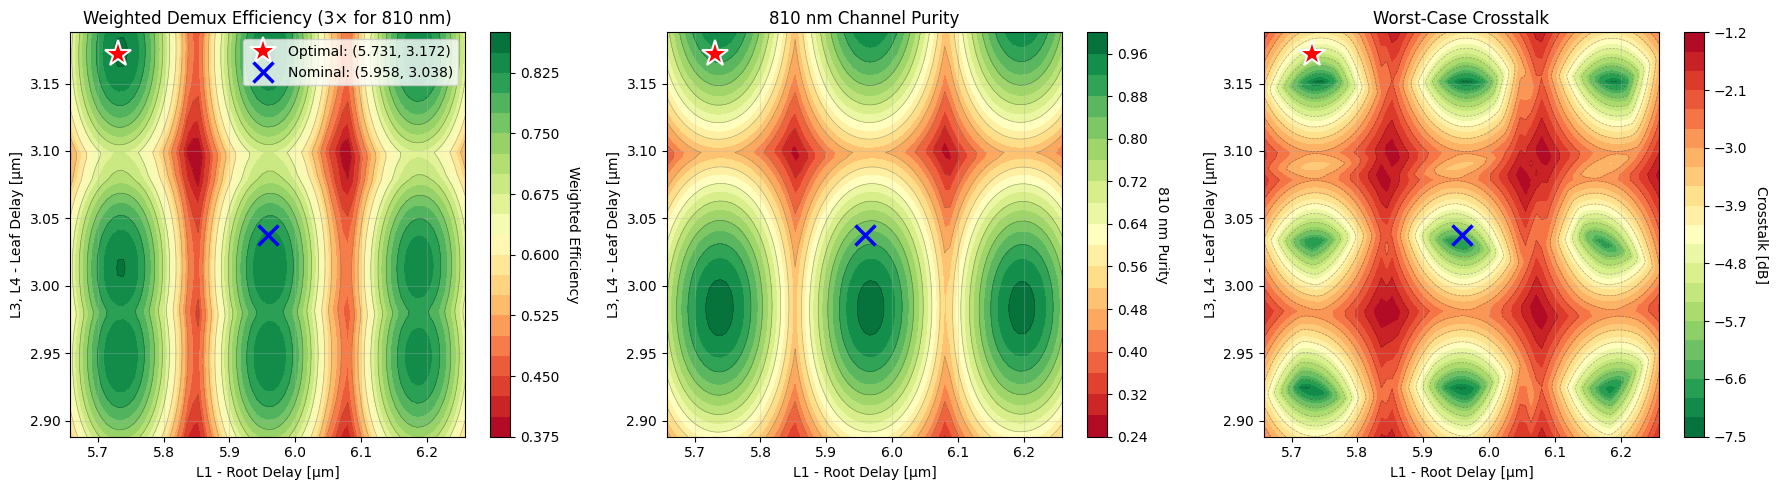


SUGGESTED TAPEOUT VARIATIONS (±3 steps around optimum):
These will let you test the sensitivity and verify the optimum on-chip:

  Variant 1: L1 = 5.5810 µm, L3 = L4 = 3.0968 µm
  Variant 2: L1 = 5.6310 µm, L3 = L4 = 3.1218 µm
  Variant 3: L1 = 5.6810 µm, L3 = L4 = 3.1468 µm
  Variant 4: L1 = 5.7310 µm, L3 = L4 = 3.1718 µm
  Variant 5: L1 = 5.7810 µm, L3 = L4 = 3.1968 µm
  Variant 6: L1 = 5.8310 µm, L3 = L4 = 3.2218 µm
  Variant 7: L1 = 5.8810 µm, L3 = L4 = 3.2468 µm


In [43]:
# Parameter sweep for optimization
import time

# Sweep around nominal values
L1_nominal = 5.958
L3_nominal = 3.038

# FOM weights: prioritize 810 nm
wavelength_weights = {
    760: 1.0,
    785: 1.0,
    810: 3.0,  # 3x weight for 810 nm - most important!
    835: 1.0
}
weights_array = np.array([wavelength_weights[wl] for wl, _ in test_lasers])
weights_array = weights_array / np.sum(weights_array)  # Normalize

print("Figure of Merit: Weighted Demux Efficiency")
print("Wavelength weights:")
for wl, w in wavelength_weights.items():
    print(f"  {wl} nm: {w:.1f}× → {weights_array[list(wavelength_weights.keys()).index(wl)]:.3f} normalized")
print()

# Define sweep ranges
# L1: ±0.3 um with 75 points (triple accuracy)
# L3: ±0.15 um with 75 points (50% smaller range, triple accuracy)
L1_values = np.linspace(L1_nominal - 0.3, L1_nominal + 0.3, 75)
L3_values = np.linspace(L3_nominal - 0.15, L3_nominal + 0.15, 75)

# Storage for results
efficiency_map = np.zeros((len(L3_values), len(L1_values)))
efficiency_map_810 = np.zeros((len(L3_values), len(L1_values)))  # Track 810 nm specifically
max_crosstalk_map = np.zeros((len(L3_values), len(L1_values)))

print(f"Running {len(L1_values)} × {len(L3_values)} = {len(L1_values)*len(L3_values)} simulations...")
print(f"L1 range: {L1_values[0]:.4f} to {L1_values[-1]:.4f} µm (step: {L1_values[1]-L1_values[0]:.5f} µm)")
print(f"L3 range: {L3_values[0]:.4f} to {L3_values[-1]:.4f} µm (step: {L3_values[1]-L3_values[0]:.5f} µm)")
print("Starting sweep...\n")

# Start timing
start_time = time.time()

# Sweep through parameter space
for i, L3_val in enumerate(L3_values):
    for j, L1_val in enumerate(L1_values):
        # Calculate channel powers for all test wavelengths
        temp_results = np.zeros((len(test_lasers), 4))
        for k, (wl, fwhm) in enumerate(test_lasers):
            result = calculate_channel_powers(
                lambda_center_nm=wl,
                fwhm_nm=fwhm,
                L1=L1_val,
                L3=L3_val,
                L4=L3_val  # Keep L4 = L3
            )
            temp_results[k, :] = result['channel_powers']
        
        # Calculate weighted demux efficiency (our figure of merit)
        channel_purity = np.max(temp_results, axis=1)
        efficiency_map[i, j] = np.sum(channel_purity * weights_array)  # Weighted average
        
        # Track 810 nm performance specifically
        idx_810 = 2  # 810 nm is the 3rd wavelength (index 2)
        efficiency_map_810[i, j] = channel_purity[idx_810]
        
        # Also track worst-case crosstalk
        max_crosstalk_map[i, j] = np.max(1 - channel_purity)
    
    # Progress indicator every 10%
    if (i + 1) % (len(L3_values) // 10) == 0:
        elapsed = time.time() - start_time
        progress = (i + 1) / len(L3_values) * 100
        print(f"  Progress: {progress:.0f}% complete ({elapsed:.1f}s elapsed)")

# End timing
end_time = time.time()
total_time = end_time - start_time

print(f"\n✓ Sweep complete!")
print(f"  Total time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"  Time per simulation: {total_time/(len(L1_values)*len(L3_values))*1000:.2f} ms")

# Find optimal parameters
best_idx = np.unravel_index(np.argmax(efficiency_map), efficiency_map.shape)
best_L3 = L3_values[best_idx[0]]
best_L1 = L1_values[best_idx[1]]
best_efficiency = efficiency_map[best_idx]
best_810_purity = efficiency_map_810[best_idx]

print(f"\n{'='*60}")
print(f"OPTIMAL PARAMETERS (weighted for 810 nm):")
print(f"  L1 = {best_L1:.4f} µm (Δ = {best_L1 - L1_nominal:+.4f} µm)")
print(f"  L3 = L4 = {best_L3:.4f} µm (Δ = {best_L3 - L3_nominal:+.4f} µm)")
print(f"  Weighted Efficiency = {best_efficiency:.3f} ({best_efficiency*100:.1f}%)")
print(f"  810 nm Purity = {best_810_purity:.3f} ({best_810_purity*100:.1f}%)")
print(f"{'='*60}\n")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax1, ax2, ax3 = axes

# Weighted Demux Efficiency map
im1 = ax1.contourf(L1_values, L3_values, efficiency_map, levels=20, cmap='RdYlGn')
ax1.contour(L1_values, L3_values, efficiency_map, levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax1.plot(best_L1, best_L3, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=1.5, 
         label=f'Optimal: ({best_L1:.3f}, {best_L3:.3f})')
ax1.plot(L1_nominal, L3_nominal, 'bx', markersize=15, markeredgewidth=2.5, 
         label=f'Nominal: ({L1_nominal:.3f}, {L3_nominal:.3f})')
ax1.set_xlabel('L1 - Root Delay [µm]')
ax1.set_ylabel('L3, L4 - Leaf Delay [µm]')
ax1.set_title('Weighted Demux Efficiency (3× for 810 nm)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Weighted Efficiency', rotation=270, labelpad=15)

# 810 nm Purity map
im2 = ax2.contourf(L1_values, L3_values, efficiency_map_810, levels=20, cmap='RdYlGn')
ax2.contour(L1_values, L3_values, efficiency_map_810, levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax2.plot(best_L1, best_L3, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=1.5)
ax2.plot(L1_nominal, L3_nominal, 'bx', markersize=15, markeredgewidth=2.5)
ax2.set_xlabel('L1 - Root Delay [µm]')
ax2.set_ylabel('L3, L4 - Leaf Delay [µm]')
ax2.set_title('810 nm Channel Purity')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('810 nm Purity', rotation=270, labelpad=15)

# Max Crosstalk map
im3 = ax3.contourf(L1_values, L3_values, 10*np.log10(max_crosstalk_map), 
                   levels=20, cmap='RdYlGn_r')
ax3.contour(L1_values, L3_values, 10*np.log10(max_crosstalk_map), 
            levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax3.plot(best_L1, best_L3, 'r*', markersize=20, markeredgecolor='white', markeredgewidth=1.5)
ax3.plot(L1_nominal, L3_nominal, 'bx', markersize=15, markeredgewidth=2.5)
ax3.set_xlabel('L1 - Root Delay [µm]')
ax3.set_ylabel('L3, L4 - Leaf Delay [µm]')
ax3.set_title('Worst-Case Crosstalk')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.set_label('Crosstalk [dB]', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Suggest fabrication variations for testing
print("\nSUGGESTED TAPEOUT VARIATIONS (±3 steps around optimum):")
print("These will let you test the sensitivity and verify the optimum on-chip:\n")
delta_L1 = 0.05  # 50 nm steps
delta_L3 = 0.025  # 25 nm steps

for step in [-3, -2, -1, 0, 1, 2, 3]:
    test_L1 = best_L1 + step * delta_L1
    test_L3 = best_L3 + step * delta_L3
    print(f"  Variant {step+4}: L1 = {test_L1:.4f} µm, L3 = L4 = {test_L3:.4f} µm")

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.optimize import curve_fit

In [9]:
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import numpy as np

def simulate_and_plot(L1, dL2):
    L2 = 2.0 * L1 + dL2  # constrained + detuned

    p_a, p_b = [], []
    p_l1, p_l2, p_l3, p_l4 = [], [], [], []

    for wl in wl_space_um:
        n_eff_wl = neff_fit_func(wl)

        # Root
        DC1 = coupler_matrix(k1)
        DC2 = coupler_matrix(k2)
        DC3 = coupler_matrix(k3)
        P1 = delay_matrix(L1, n_eff_wl, wl)
        P2 = delay_matrix(L2, n_eff_wl, wl)
        root =  DC2 @ P1 @ DC1

        Ebranch = root @ Ein
        E_to_leaf_1, E_to_leaf_2 = Ebranch[0], Ebranch[1]
        p_a.append(np.abs(E_to_leaf_1)**2)
        p_b.append(np.abs(E_to_leaf_2)**2)

        E_input_to_leaf_1 = np.array([E_to_leaf_1, 0.0], dtype=complex)
        E_input_to_leaf_2 = np.array([E_to_leaf_2, 0.0], dtype=complex)

        # Leaf A
        DC4 = coupler_matrix(k4)
        DC5 = coupler_matrix(k5)
        P3 = delay_matrix(L3, n_eff_wl, wl)
        leaf_a = DC5 @ P3 @ DC4
        EleafA = leaf_a @ E_input_to_leaf_1
        EA_1, EA_2 = EleafA[0], EleafA[1]

        # Leaf B
        DC6 = coupler_matrix(k4)
        DC7 = coupler_matrix(k5)
        P4 = delay_matrix(L4, n_eff_wl, wl)
        leaf_b = DC7 @ P4 @ DC6
        EleafB = leaf_b @ E_input_to_leaf_2
        EB_1, EB_2 = EleafB[0], EleafB[1]

        p_l1.append(np.abs(EA_1)**2)
        p_l2.append(np.abs(EA_2)**2)
        p_l3.append(np.abs(EB_1)**2)
        p_l4.append(np.abs(EB_2)**2)

    # Plot: root split
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    for wl_target in wl_um:
        ax.axvline(wl_target * 1e3, color='gray', linestyle='--', alpha=0.5)

    ax.plot(wl_space_um * 1e3, p_a, label='Power to Leaf A', alpha=0.7)
    ax.plot(wl_space_um * 1e3, p_b, label='Power to Leaf B', alpha=0.7)

    ax.set_title(f'Root Split vs Wavelength\nL1={L1:.3f} µm, L2={L2:.3f} µm (dL2={dL2:.3f} µm)')
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Power')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.2)
    plt.show()

interact(
    simulate_and_plot,
    L1=FloatSlider(
        value=1.0, min=0.2, max=20.0, step=0.01,
        description='L1 (µm)', continuous_update=False
    ),
    dL2=FloatSlider(
        value=0.0, min=0.0, max=3.0, step=0.001,
        description='dL2 (µm)', continuous_update=False
    )
);


interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='L1 (µm)', max=20.0, min=0.2…